# SLT-CE-2: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 (If you cannot access, you can try the same link after configuring your ETH VPN.)

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt23_lecture05.pdf 

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/lectures/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42) 

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

## Texture and corresponding label map
(This texture is used to fit your model.)

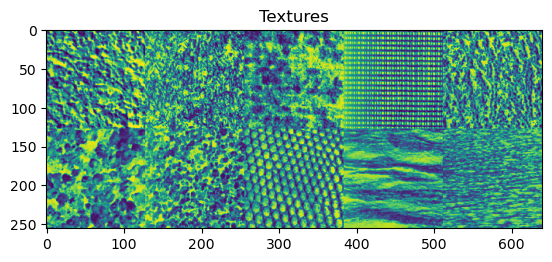

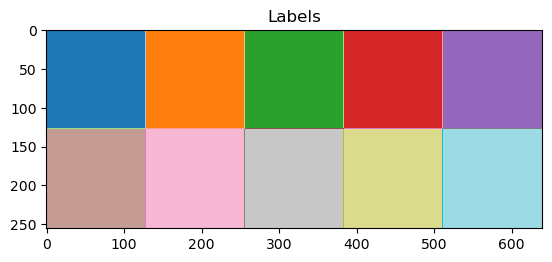

In [2]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

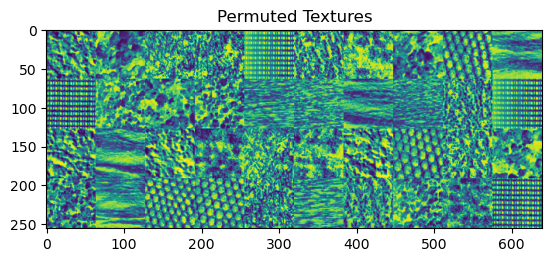

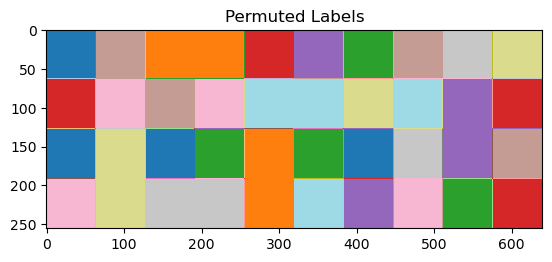

In [3]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.<br>
Hint 2: See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.
</p>

Put your recap here.
In order to compute the maximum a posteriori estimates, we have to maximize the log-posterior distribution. Given are a set of abstract objects $\textbf{X}$, a domain of nominal features $\textbf{Y}$, $n(x,y)$, which counts how often a feature $y$ has been observed for a particular $x$, $n(x)=\sum_{y\in Y} n(x,y)$ and $\hat{P}(y|x)=\frac{n(x,y)}{n(x)}$, which is the empirical distribution given $x$.

We need to maximize: 

\begin{align*}
\textbf{L}(\textbf{c},\theta;\textbf{n})=\log{P(\textbf{c})} + \sum_{x\in \textbf{X}} n(x)[\log{P(x)}+\sum_{y\in\textbf{Y}}\hat{P}(y|x)\log{P(y|\textbf{c}(x))}]
\end{align*}


We obtain the following:
\begin{align*}
\hat{P}(x) = \frac{n(x)}{\sum_{x^{\prime}\in \textbf{X}}n(x^{\prime})},
\end{align*}
\begin{align*}
\hat{P}(y|c) = \sum_{x:\hat{\textbf{c}}(x)=c}\frac{n(x)}{\sum_{x^{\prime}:\hat{\textbf{c}}(x^{\prime})=c}n(x^{\prime})}\hat{P}(y|x),
\end{align*}
\begin{align*}
\hat{\textbf{c}}(x)=\arg\min_a \left\{-\sum_{y\in \textbf{Y}}\hat{P}(y|x)\log{\hat{P}(y|a) -\log{P(\hat{\textbf{c}}_a^x)}}\right\},
\end{align*}
where $\hat{\textbf{c}}_a^x(x)=a$ and $\hat{\textbf{c}}_a^x(x^{\prime})=\hat{\textbf{c}}(x^{\prime})$ for $x^{\prime}\ne x$ are the class assignments obtained by changing the assignment of $x$ to class $a$.

The components of $\hat{P}(y|c)$ define probabilities for feature values. Therefore, we deal with distributions over features as centroids for all objects which are assigned to a particular cluster.

By an alternating maximization scheme, assignments are first calculated (given the centroids) and the centroids distributions are then computed.

With DA, we are able to avoid local minima, by introducing a temperature parameter.

In the case of DA, equation (5) becomes $\hat{P}(y|c)=\frac{\sum_{x\in \textbf{X}}\hat{P}(y|x) P(\textbf{c}(x)=c|\textbf{n}, \hat{\theta})}{\sum_{x\in \textbf{X}} P(\textbf{c}(x)=c|\textbf{n}, \hat{\theta})}$, where $P(\textbf{c}(x)=a|\textbf{n}, \hat{\theta})=\frac{\exp\{-n(x) D_{KL}[\hat{P}(\cdot|x)||\hat{P}(\cdot|a)]/T\}}{\sum_{b\in\textbf{C}}\exp\{-n(x)D_{KL}[\hat{P}(\cdot|x)||\hat{P}(\cdot|b)]/T\}}$.

This results from the minimization of the cost function, which is equivalent to the negative log-likelihood (cfr. formula (8) in [1]).

\begin{align*}
R(\textbf{c},\theta;\textbf{n}) = - \textbf{L}(\textbf{c},\theta;\textbf{n}) = \sum_{x\in\textbf{X}}n(x)D_{KL}[\hat{P}(\cdot|x)||P(\cdot|c(x))] = \sum_{x\in\textbf{X}} n(x) \sum_{y\in\textbf{Y}}\hat{P}(y|x)\log{\frac{\hat{P}(y|x)}{P(y|c(x))}}
\end{align*}

\begin{align*}
\implies R(\textbf{c},\theta;\textbf{n}) = -\sum_{x\in\textbf{X}} n(x) \sum_{y\in\textbf{Y}}\hat{P}(y|x)\log{P(y|c(x))} + const.
\end{align*}

The lagrangian is:

\begin{align*}
\mathcal{L} = H(P(c|\textbf{n}, \hat{\theta}))+\sum_{c\in\textbf{C}}\lambda_c(1-\sum_{y\in\textbf{Y}}P(y|c))
\end{align*}

Using the centroid condition (cfr course notes, chapter 3):
\begin{align*}
\frac{\partial H}{\partial P(y|c)} = -\frac{1}{T}E_{c\sim P(\cdot|\textbf{n},\hat{\theta})}\left[\frac{\partial R(\textbf{c},\theta;\textbf{n})}{\partial P(y|c)}\right] = \frac{1}{T}\sum_{x\in\textbf{X}}n(x)\sum_{y\in\textbf{Y}}\hat{P}(y|x)P(c|\textbf{n},\hat{\theta})\frac{1}{P(y|c)}
\end{align*}

Hence,
\begin{align*}
\frac{\partial\mathcal{L}}{\partial P(y|c)} = -\frac{1}{T}E_{c\sim P(\cdot|\textbf{n},\hat{\theta})}\left[\frac{\partial R(\textbf{c},\theta;\textbf{n})}{\partial P(y|c)}\right] - \lambda_c
\end{align*}

Setting this derivative to $0$ and solving for $P(y|c)$ yields the equation written above.

The solution can be found through an iterative scheme and data over-fitting can be avoided after choosing the right value for the temperature parameter.    

In [4]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=42, estimation="MAP",
                 maxit=200, printit=False, eta=0.9, Tstart=10, Tstop=0.1, store_centroids=True):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
        self.maxit = maxit
        self.printit = printit
        self.eta = eta
        self.Tstart = Tstart
        self.Tstop = Tstop
        self.store_centroids = store_centroids
    
    def fit(self, X):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        
        nxy = np.zeros((X.size, self.n_bins))
        self.edges = np.linspace(X.min(), X.max(), self.n_bins+1)
        
        for idx in range(X.size):
            i, j = np.unravel_index(idx, X.shape)
            patch = X[np.max([0, i - (self.window_size-1)//2]):np.min([X.shape[0], i + (self.window_size+1)//2]),
                      np.max([0, j - (self.window_size-1)//2]):np.min([X.shape[1], j + (self.window_size+1)//2])].ravel()
            nxy[idx,], _ = np.histogram(patch, self.edges)
            
        nx = nxy.sum(axis=1)
        p_hat_y_given_x = nxy/nx[:,np.newaxis]
        
        # Assume uniform prior on c
        c_tmp = np.random.choice(np.arange(self.n_clusters), size=X.size)
        
        if self.estimation == "MAP":

            # Code for Maximum a Posteriori estimation
            count = 1
            stop = False
            
            while not stop:
                
                if self.printit:
                    print(count)
                if count == self.maxit: 
                    stop = True
                    
                p_hat_y_given_c = np.zeros((self.n_clusters, self.n_bins))
                # Calculate P_hat(y|c)
                for c in range(self.n_clusters):
                    pos = np.where(c_tmp == c)
                    den = np.sum(nx[pos])
                    p_hat_y_given_c[c,:] = np.dot(nx[np.newaxis, pos],
                                                  p_hat_y_given_x[pos,:])/den
                
                # Calculate centroids
                # Considering equation (6) in [1], we can ignore the term log(P(\hat{c}_a^x) because
                # we assumed uniform prior for the clusters
                p_hat_y_given_c[p_hat_y_given_c == 0] = 1e-10
                c_new = np.argmin(-np.dot(p_hat_y_given_x, np.log(p_hat_y_given_c).T), axis=1)
                
                if (c_new == c_tmp).all():
                    stop = True    
                c_tmp = c_new
                count += 1
                
            self.centroids = p_hat_y_given_c
                

        elif self.estimation == "DA":
            
            if self.store_centroids:
                self.centroids_dict = {}
            
            # Code for Deterministic Annealing estimation
            # Initialization p_hat_y_given_c at the center of mass
            p_hat_y_given_c_tmp = np.tile(np.mean(p_hat_y_given_x, axis=0), (self.n_clusters,1))
            
            p_hat_y_given_c_tmp = p_hat_y_given_c_tmp + 1e-3 * np.random.uniform(low=0, high=1, size=p_hat_y_given_c_tmp.shape)
            p_hat_y_given_c_tmp = p_hat_y_given_c_tmp/np.sum(p_hat_y_given_c_tmp, axis=1)[:,np.newaxis]
            
            temp = self.Tstart
            self.Tend = self.Tstop # Tend is the temperature once the loop is over, used for prediction
            while temp > self.Tstop:
                print(f'Temperature: {temp}')
                stop = False
                
                while not stop:
                    if np.any(p_hat_y_given_c_tmp == 0) :
                        p_hat_y_given_c_tmp += 1e-10
                        p_hat_y_given_c_tmp = p_hat_y_given_c_tmp/np.sum(p_hat_y_given_c_tmp, axis=1)[:,np.newaxis]
                    div = p_hat_y_given_x / p_hat_y_given_c_tmp.reshape(self.n_clusters, 1, self.n_bins)
                    if (div == 0).any():
                        div += 1e-10
                    D_KL = np.sum(
                        p_hat_y_given_x * np.log(div),
                        axis = 2
                    ) # dimension self.n_clusters * X.size
                    num = np.exp(-(1/temp) * nx[:,np.newaxis] * D_KL.T) # X.size * self.n_clusters
                    p_c_given_theta = num/np.sum(num, axis=1)[:,np.newaxis] # X.size * self.n_clusters
                    p_hat_y_given_c_new = (np.dot(p_hat_y_given_x.T, p_c_given_theta)/
                                           np.sum(p_c_given_theta, axis=0)[np.newaxis,:]) # self.n_bins * self.n_clusters
                    p_hat_y_given_c_new = p_hat_y_given_c_new.T
                    
                    if np.allclose(p_hat_y_given_c_tmp, p_hat_y_given_c_new):
                        p_hat_y_given_c_tmp = p_hat_y_given_c_new
                        stop = True
                    p_hat_y_given_c_tmp = p_hat_y_given_c_new
                    
                if self.store_centroids:
                    self.centroids_dict[temp] = p_hat_y_given_c_new
                
                # adding random noise    
                p_hat_y_given_c_tmp = p_hat_y_given_c_tmp + 1e-3 * np.random.uniform(low=0, high=1, size=p_hat_y_given_c_tmp.shape)
                p_hat_y_given_c_tmp = p_hat_y_given_c_tmp/np.sum(p_hat_y_given_c_tmp, axis=1)[:,np.newaxis]
                
                
                self.Tend = temp
                temp *= self.eta
                
            self.centroids = p_hat_y_given_c_new
        
        return self
    
    def predict(self, X, temp=None):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            temp: either None or temperature to be used for the prediction
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        nxy = np.zeros((X.size, self.n_bins))
        edges = np.linspace(X.min(), X.max(), self.n_bins+1)
        
        for idx in range(X.size):
            i, j = np.unravel_index(idx, X.shape)
            patch = X[np.max([0, i - (self.window_size-1)//2]):np.min([X.shape[0], i + (self.window_size+1)//2]),
                      np.max([0, j - (self.window_size-1)//2]):np.min([X.shape[1], j + (self.window_size+1)//2])].ravel()
            nxy[idx,], _ = np.histogram(patch, edges)
            
        nx = nxy.sum(axis=1)
        p_hat_y_given_x = nxy/nx[:,np.newaxis]
        
        if self.estimation == "MAP":
            C = np.argmin(-np.dot(p_hat_y_given_x, np.log(self.centroids).T), axis=1).reshape(X.shape)
        
        elif self.estimation == "DA":
            if temp is None:
                centroids = self.centroids
                temp = self.Tend
            else :
                centroids = self.centroids_dict[temp]
            if np.any(centroids == 0) :
                centroids += 1e-10
                centroids = centroids/np.sum(centroids, axis=1)[:,np.newaxis]
            div = p_hat_y_given_x / centroids.reshape(self.n_clusters, 1, self.n_bins)
            if (div == 0).any():
                div += 1e-10
            D_KL = np.sum(
                p_hat_y_given_x * np.log(div),
                axis = 2
            )
            num = np.exp(-(1/temp) * nx[:,np.newaxis] * D_KL.T)
            p_c_given_theta = num/np.sum(num, axis=1)[:,np.newaxis]
            C = np.argmax(p_c_given_theta, axis=1).reshape(X.shape)

        return C
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        C_reshaped = C.reshape((-1,1))
        
        bin_centers = (self.edges[1:] + self.edges[:-1])/2
        
        def get_probs(cluster_value):
            return self.centroids[cluster_value,]
            
        X = np.array(list(map(lambda x: np.random.choice(bin_centers, p=get_probs(int(x))), C_reshaped))).reshape(C.shape)
        
        return X

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

After having done part 4.5 and realizing the importance of $\texttt{n_bins}$ and $\texttt{window_size}$ for the quality of the results, I chose to increase both of them.

In [5]:
%%time
HC1 = HistogramClustering(printit=True, n_bins=128, window_size=11)
HC1.fit(texture)
check_is_fitted(HC1, ["centroids"])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
CPU times: total: 5.14 s
Wall time: 9.83 s


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [6]:
%%time
predicted_perm_label_map = HC1.predict(perm_texture)

CPU times: total: 5.39 s
Wall time: 6.33 s


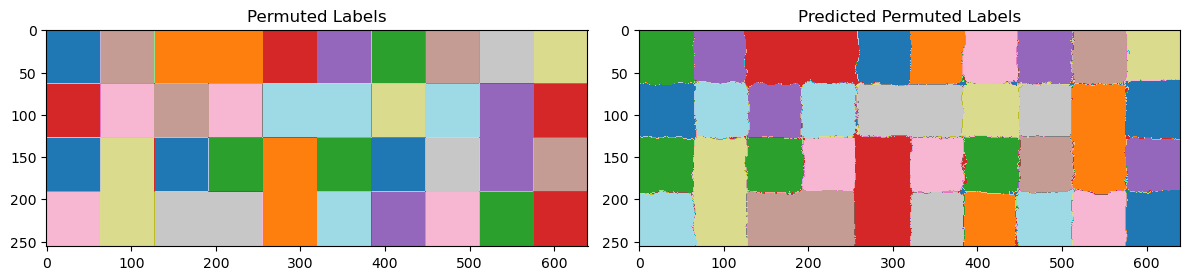

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(perm_label_map, cmap="tab20")
axs[0].set_title("Permuted Labels")
axs[1].imshow(predicted_perm_label_map, cmap="tab20")
axs[1].set_title("Predicted Permuted Labels")
plt.tight_layout()
plt.show()

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

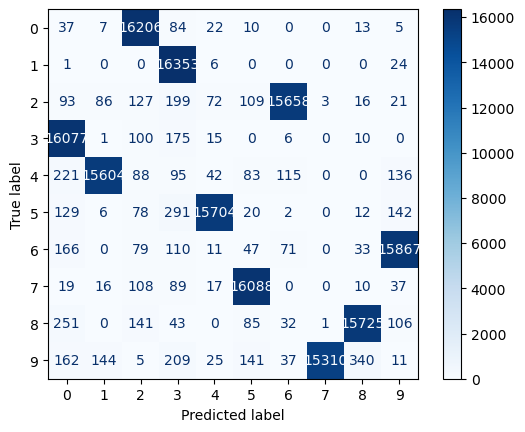

In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confmat = confusion_matrix(perm_label_map.ravel(), predicted_perm_label_map.ravel())
ConfusionMatrixDisplay(confmat).plot(cmap='Blues')
plt.show()

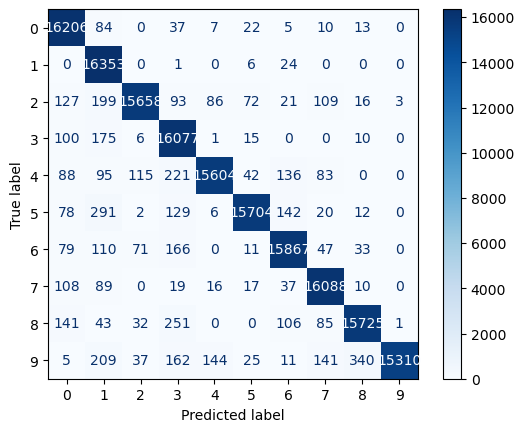

In [13]:
from scipy.optimize import linear_sum_assignment

row_idx, col_idx = linear_sum_assignment(confmat, maximize=True)
confmat_permuted = confmat[row_idx,:][:,col_idx]
ConfusionMatrixDisplay(confmat_permuted).plot(cmap='Blues')
plt.show()

In [10]:
np.sum(np.diag(confmat_permuted))/np.sum(confmat_permuted)

0.96796875

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [22]:
# 3x3 Matrix with accuracy scores of the different parameter combination
n_bins_list = [16, 32, 64]
window_size_list = [7, 9, 11]

acc_mat = np.zeros((len(n_bins_list), len(window_size_list)))
predictions = np.zeros((texture.shape[0], texture.shape[1], len(n_bins_list)*len(window_size_list)))

count=0
for i in range(len(n_bins_list)) :
    for j in range(len(window_size_list)) :
        HC_acc = HistogramClustering(n_bins=n_bins_list[i], window_size=window_size_list[j])
        HC_acc.fit(texture)
        predicted_perm_label_map_acc = HC_acc.predict(perm_texture)
        predictions[:,:,count] = predicted_perm_label_map_acc
        confmat_acc = confusion_matrix(perm_label_map.ravel(), predicted_perm_label_map_acc.ravel())
        row_idx_acc, col_idx_acc = linear_sum_assignment(confmat_acc, maximize=True)
        confmat_permuted_acc = confmat_acc[row_idx_acc,:][:,col_idx_acc]
        acc_mat[i,j] = np.sum(np.diag(confmat_permuted_acc))/np.sum(confmat_permuted_acc)
        print(f'n_bins: {n_bins_list[i]}, window_size: {window_size_list[j]}, accuracy: {acc_mat[i,j]}')
        count += 1

n_bins: 16, window_size: 7, accuracy: 0.260687255859375
n_bins: 16, window_size: 9, accuracy: 0.276116943359375
n_bins: 16, window_size: 11, accuracy: 0.28876953125
n_bins: 32, window_size: 7, accuracy: 0.315411376953125
n_bins: 32, window_size: 9, accuracy: 0.371380615234375
n_bins: 32, window_size: 11, accuracy: 0.398504638671875
n_bins: 64, window_size: 7, accuracy: 0.554913330078125
n_bins: 64, window_size: 9, accuracy: 0.64871826171875
n_bins: 64, window_size: 11, accuracy: 0.704815673828125


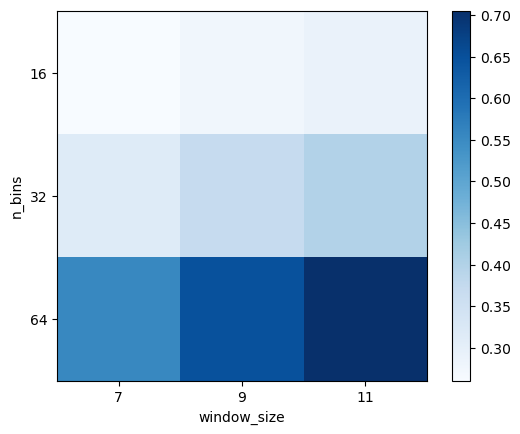

In [23]:
plt.ylabel('n_bins')
plt.xlabel('window_size')
tick_marks_x = np.arange(len(window_size_list))
tick_marks_y = np.arange(len(n_bins_list))
plt.xticks(tick_marks_x, window_size_list)
plt.yticks(tick_marks_y, n_bins_list)
plt.imshow(acc_mat, cmap='Blues')
plt.colorbar()

As we can see, both the number of bins and the window size play a crucial role for the quality of the result. In partucular, the larger the number of bins and the size of the window, the higher the accuracy. The difference is even more evident when going from $\texttt{n_bins}=32$ to $\texttt{n_bins}=64$.

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

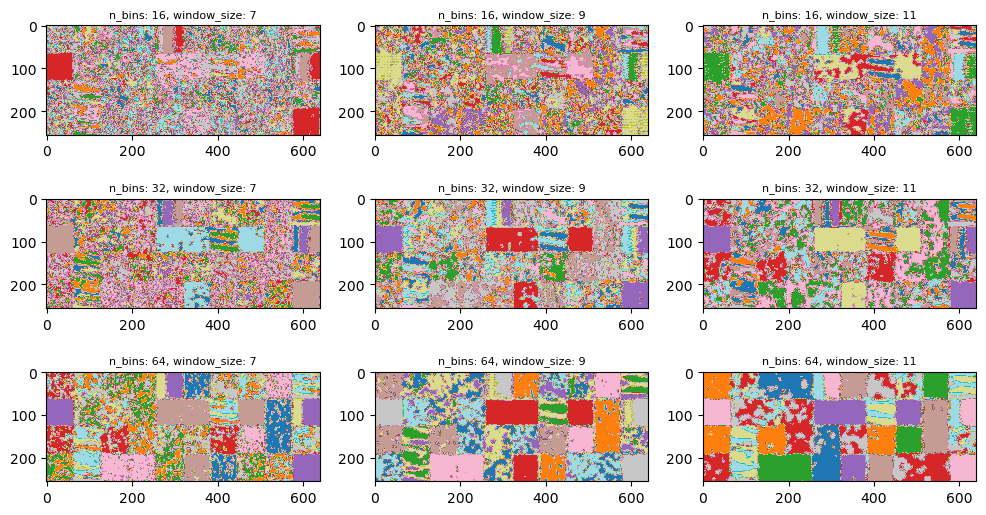

In [24]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
fig, axes = plt.subplots(len(n_bins_list), len(window_size_list), figsize=(12,12))
count=0
for i in range(len(n_bins_list)) :
    for j in range(len(window_size_list)) :
        axes[i,j].imshow(predictions[:,:,count], cmap="tab20")
        axes[i,j].set_title(f'n_bins: {n_bins_list[i]}, window_size: {window_size_list[j]}', fontsize=8)
        count += 1
        
plt.subplots_adjust(hspace=-0.7)
plt.show()

The plots confirm the conclusion made in the previous point.

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

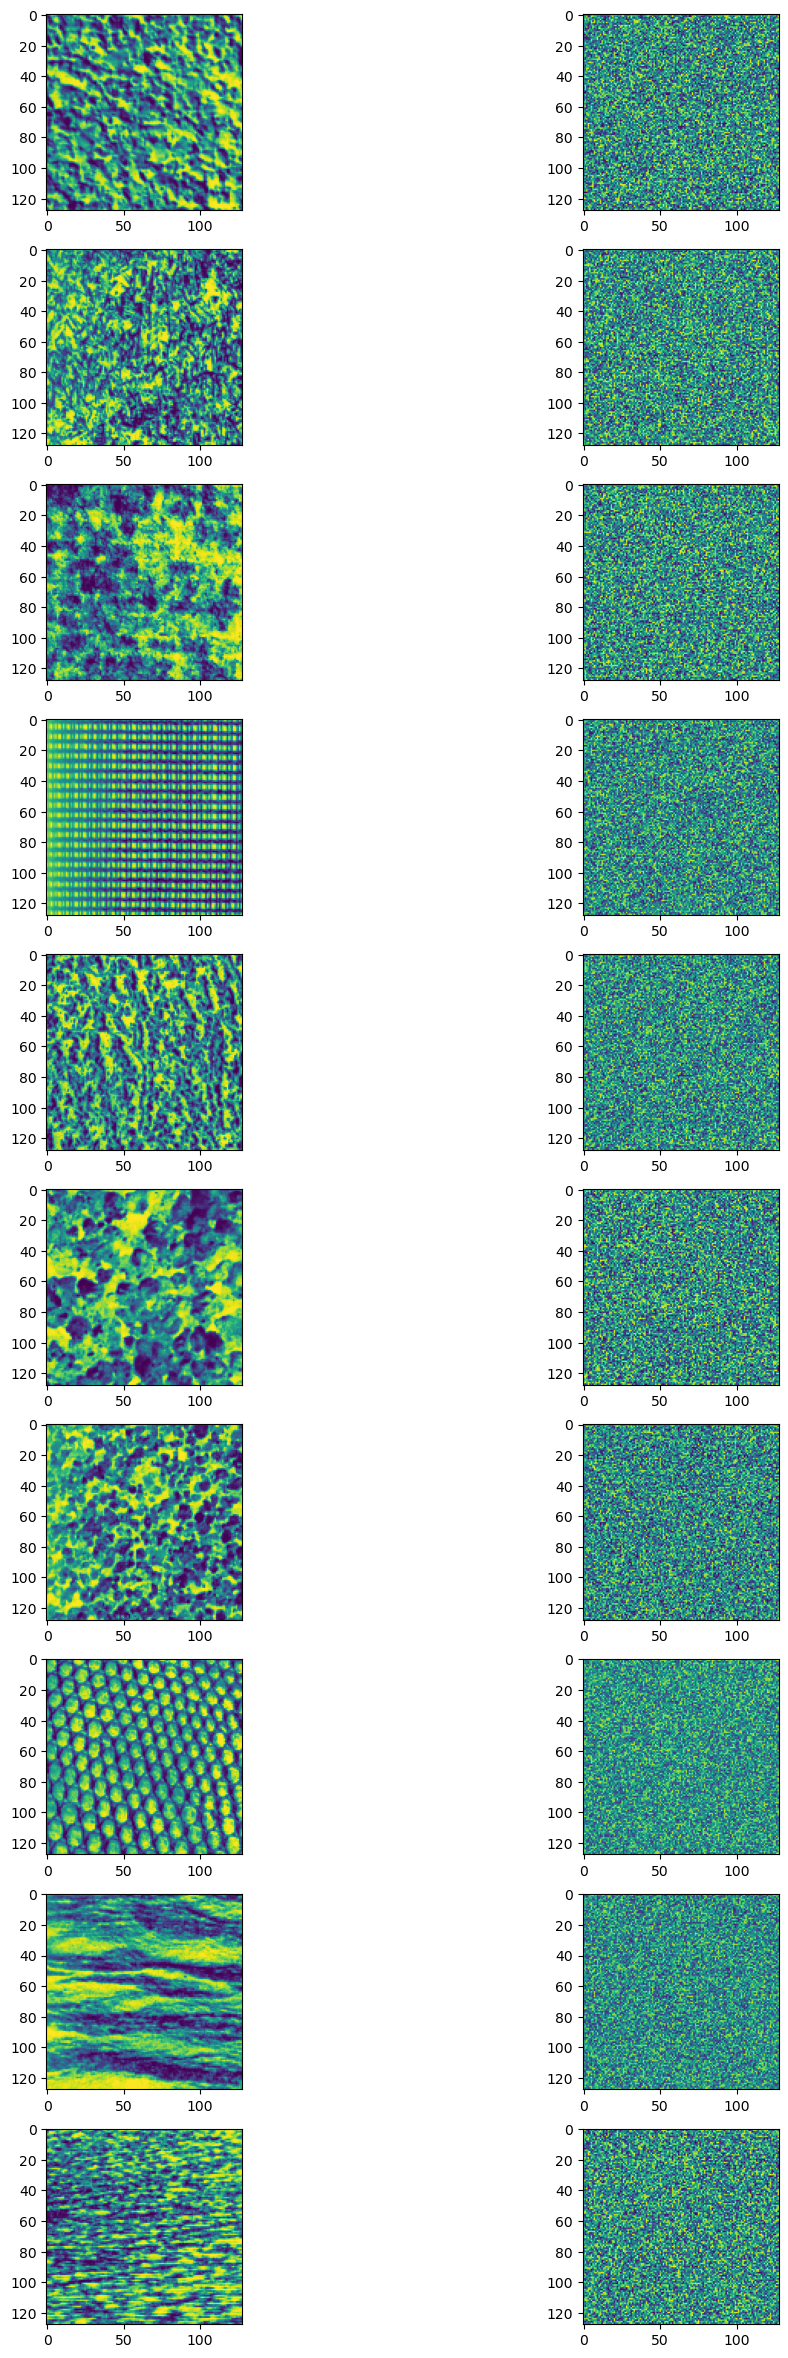

In [25]:
# C1 = np.ones(patch_shape) * 0
# X1 = HC.generate(C1)

fig, axes = plt.subplots(10, 2, figsize=(30,30))
# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.
for idx in range(10) :
    C = np.ones(patch_shape) * idx
    X_gen = HC1.generate(C)
    i, j = np.unravel_index(idx, patch_grid_shape)
    X_true = texture[patch_shape[0] * i:patch_shape[0] * (i + 1), \
                     patch_shape[1] * j:patch_shape[1] * (j + 1)]
    axes[idx,0].imshow(X_true)
    axes[idx,1].imshow(X_gen)

# Generated texture plot
plt.subplots_adjust(wspace=-0.7)
plt.show()

As we can see, we get the colors correctly represented, but not the textures. We would have to put them in our feature set. 

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [27]:
from sklearn.cluster import KMeans

window_size = 11
n_bins = 128

def get_hist(X) :
    nxy = np.zeros((X.size, n_bins))
    edges = np.linspace(X.min(), X.max(), n_bins+1)
        
    for idx in range(X.size):
        i, j = np.unravel_index(idx, X.shape)
        patch = X[np.max([0, i - (window_size-1)//2]):np.min([X.shape[0], i + (window_size+1)//2]),
                  np.max([0, j - (window_size-1)//2]):np.min([X.shape[1], j + (window_size+1)//2])].ravel()
        nxy[idx,], _ = np.histogram(patch, edges)
            
    nx = nxy.sum(axis=1)
    p_hat_y_given_x = nxy/nx[:,np.newaxis]
    return p_hat_y_given_x


# Predicted label map for k-means
km = KMeans(n_clusters=10, n_init='auto')
km.fit(get_hist(texture))
km_pred = km.predict(get_hist(perm_texture)).reshape(perm_texture.shape)

# Predicted label map for HC
HC2 = HistogramClustering(n_clusters=10, n_bins=n_bins, window_size=window_size)
HC2.fit(texture)
HC2_pred = HC2.predict(perm_texture)

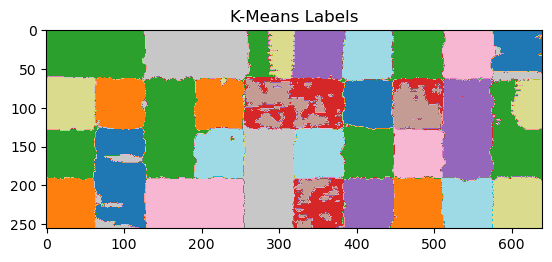

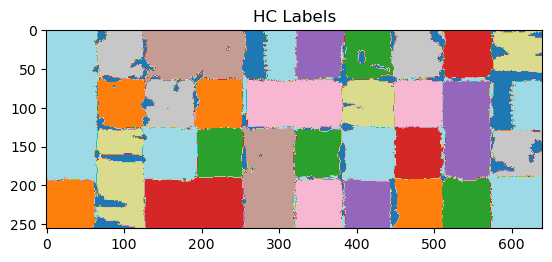

In [28]:
# KMeans
plt.imshow(km_pred, cmap="tab20")
plt.title("K-Means Labels")
plt.figure()

# HC
plt.imshow(HC2_pred, cmap="tab20")
plt.title("HC Labels")
plt.show()

Histogram Clustering seems to perform slightly better since some clusters seem to be better represented, but the difference is not so evident.

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

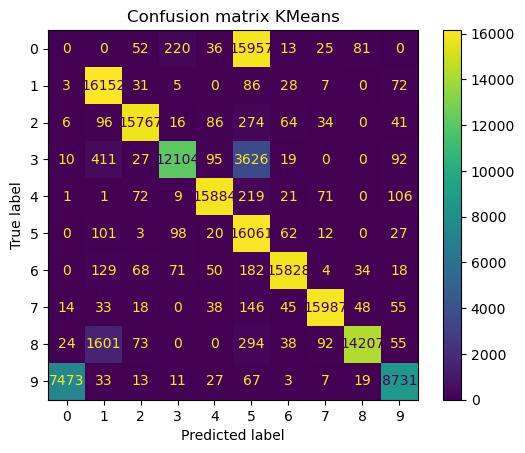

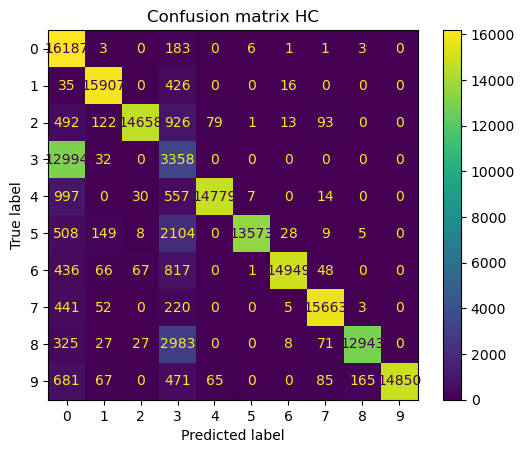

In [29]:
# Confusion matrices
km_confmat = confusion_matrix(perm_label_map.ravel(), km_pred.ravel())
row_idx_km, col_idx_km = linear_sum_assignment(km_confmat, maximize=True)
km_confmat_permuted = km_confmat[row_idx_km,:][:,col_idx_km]
ConfusionMatrixDisplay(km_confmat_permuted).plot()
plt.title('Confusion matrix KMeans')
plt.show()

HC_confmat = confusion_matrix(perm_label_map.ravel(), HC2_pred.ravel())
row_idx_HC, col_idx_HC = linear_sum_assignment(HC_confmat, maximize=True)
HC_confmat_permuted = HC_confmat[row_idx_HC,:][:,col_idx_HC]
ConfusionMatrixDisplay(HC_confmat_permuted).plot()
plt.title('Confusion matrix HC')
plt.show()

In [30]:
# accuracy 
km_acc = np.sum(np.diag(km_confmat_permuted))/np.sum(km_confmat_permuted)
HC_acc = np.sum(np.diag(HC_confmat_permuted))/np.sum(HC_confmat_permuted)

print(f'Accuracy K-Means: {km_acc}')
print(f'Accuracy HC:{HC_acc}')

Accuracy K-Means: 0.797857666015625
Accuracy HC:0.835369873046875


Even though the accuracy with Histogram Clustering is higher, the performances are quite similar.

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>


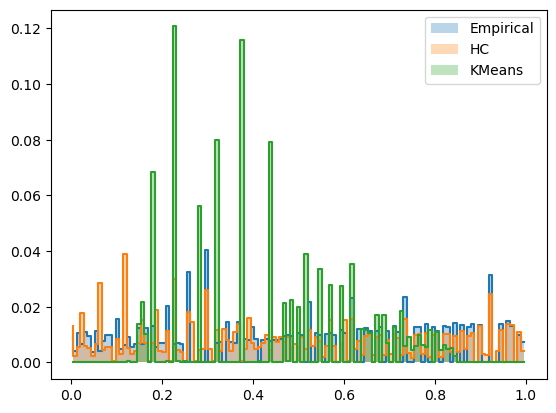

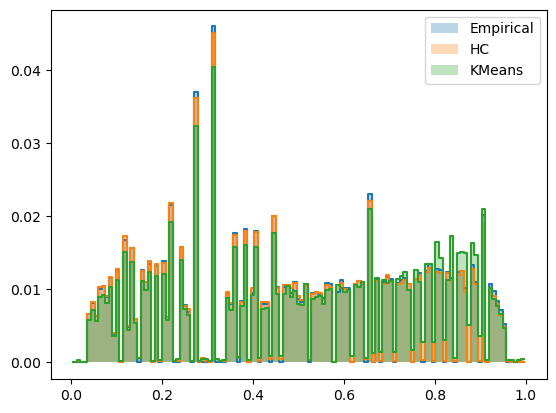

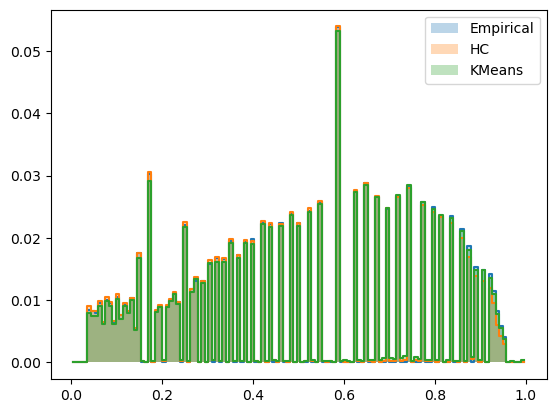

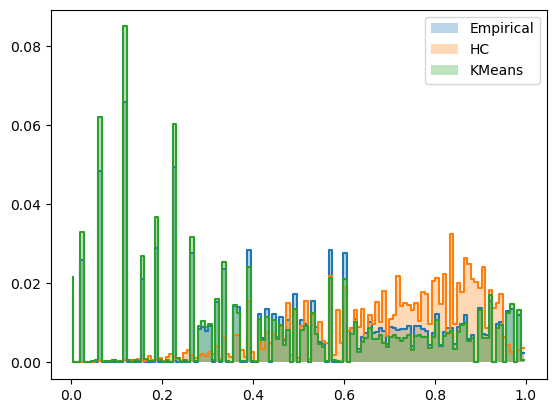

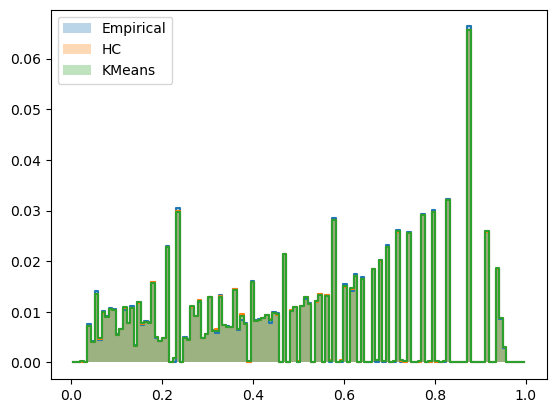

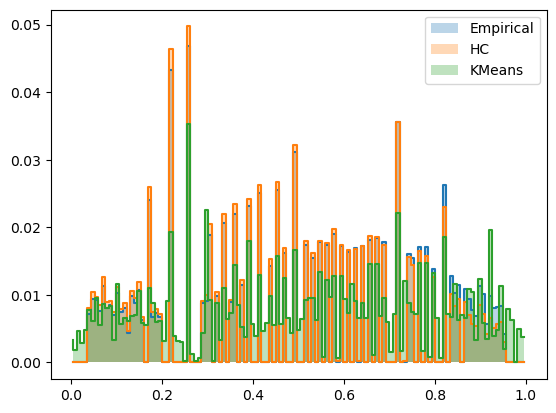

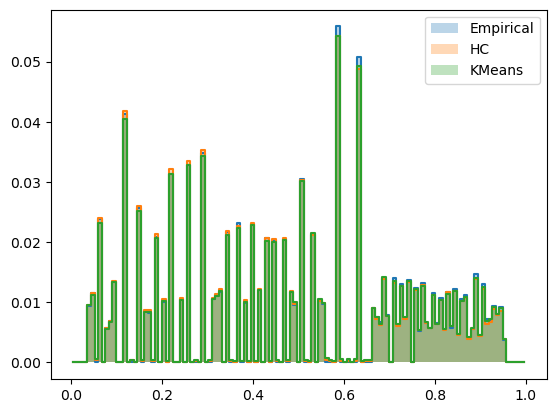

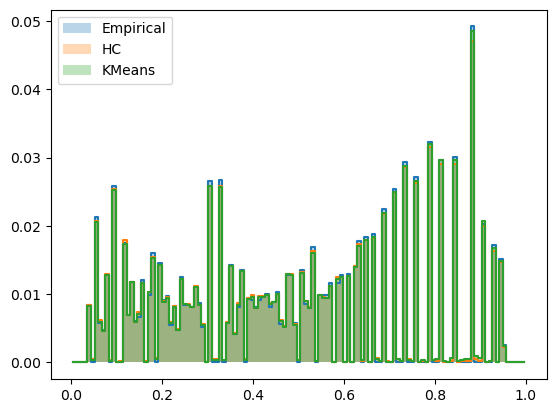

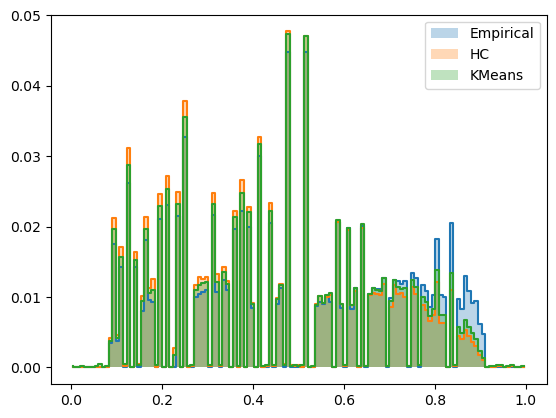

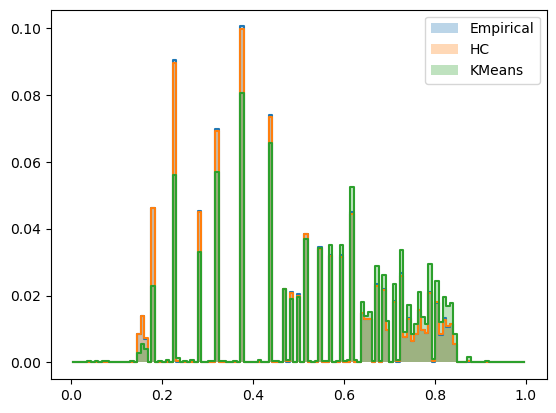

In [34]:
# Histograms
edges = np.linspace(texture.min(), texture.max(), n_bins+1)
centers = (edges[1:] + edges[:-1])/2
for i in range(10) :
    patch = texture[label_map==i]
    emp_hist, _ = np.histogram(patch, edges)
    emp_hist = emp_hist/np.sum(emp_hist)
    plt.fill_between(centers, emp_hist, step="pre", alpha=0.3)
    plt.fill_between(centers, HC2.centroids[col_idx_HC,][i,], step="pre", alpha=0.3)
    plt.fill_between(centers, km.cluster_centers_[col_idx_km,][i,], step="pre", alpha=0.3)
    plt.plot(centers, emp_hist, drawstyle="steps")
    plt.plot(centers, HC2.centroids[col_idx_HC,][i,], drawstyle="steps")
    plt.plot(centers,km.cluster_centers_[col_idx_km,][i,], drawstyle="steps")
    plt.legend(['Empirical', 'HC', 'KMeans'])
    plt.show()

Also from the histograms, we can see that the k-means performs worse compared to histogram clustering, because the histograms with the latter are more aligned to the empirical histograms

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [50]:
%%time
HC_detann = HistogramClustering(estimation="DA", n_bins=64, window_size=11, Tstart=20, Tstop=0.5, eta=0.9)
HC_detann.fit(texture)
check_is_fitted(HC_detann, ["centroids"])

Temperature: 20
Temperature: 18.0
Temperature: 16.2
Temperature: 14.58
Temperature: 13.122
Temperature: 11.809800000000001
Temperature: 10.628820000000001
Temperature: 9.565938000000001
Temperature: 8.6093442
Temperature: 7.748409780000001
Temperature: 6.973568802000001
Temperature: 6.276211921800001
Temperature: 5.64859072962
Temperature: 5.083731656658
Temperature: 4.5753584909922
Temperature: 4.11782264189298
Temperature: 3.706040377703682
Temperature: 3.3354363399333136
Temperature: 3.0018927059399823
Temperature: 2.701703435345984
Temperature: 2.4315330918113855
Temperature: 2.188379782630247
Temperature: 1.9695418043672224
Temperature: 1.7725876239305
Temperature: 1.5953288615374501
Temperature: 1.435795975383705
Temperature: 1.2922163778453346
Temperature: 1.1629947400608012
Temperature: 1.046695266054721
Temperature: 0.9420257394492489
Temperature: 0.847823165504324
Temperature: 0.7630408489538917
Temperature: 0.6867367640585025
Temperature: 0.6180630876526523
Temperature: 0.55

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

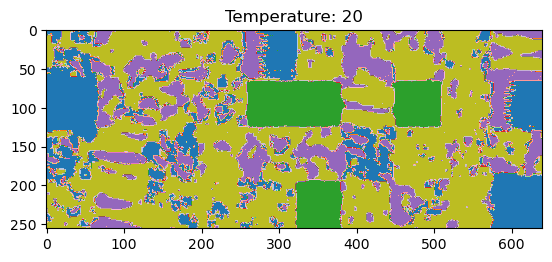

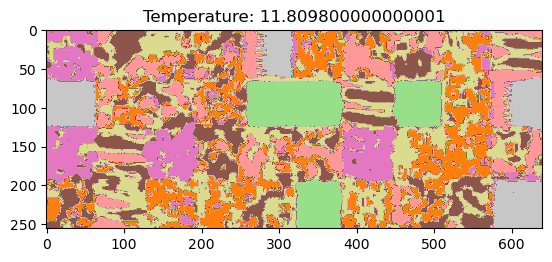

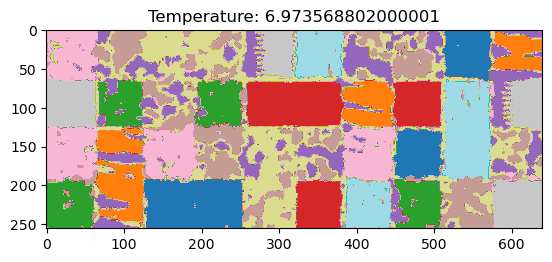

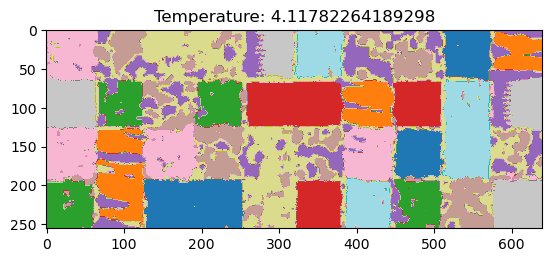

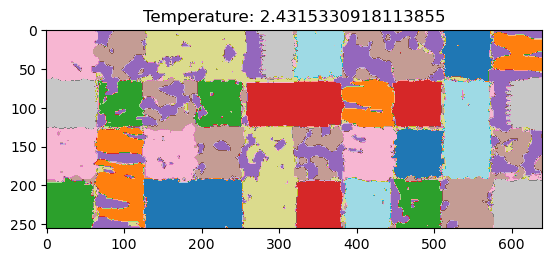

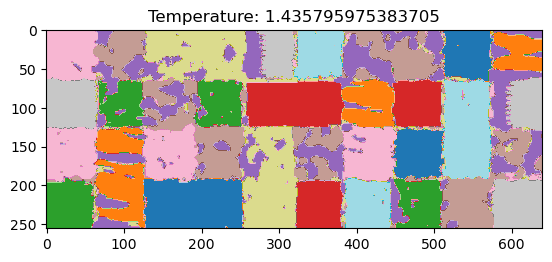

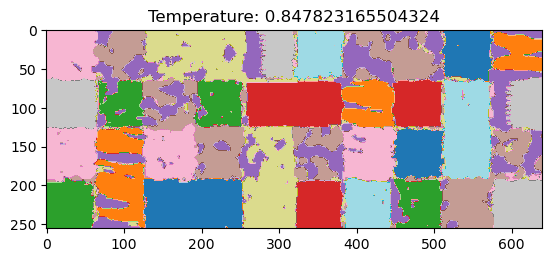

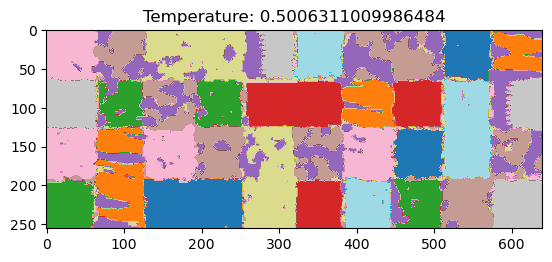

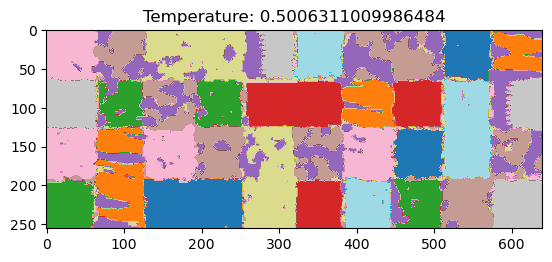

In [61]:
# Clustering at different temperatures
temps = list(HC_detann.centroids_dict.keys())
for i in range(len(temps)):
    if i % 5 == 0 :
        predicted_perm_label_map = HC_detann.predict(perm_texture, temp=temps[i])
        plt.imshow(predicted_perm_label_map, cmap="tab20")
        plt.title(f'Temperature: {temps[i]}')
        plt.show()
predicted_perm_label_map = HC_detann.predict(perm_texture, temp=temps[-1])
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title(f'Temperature: {temps[-1]}')
plt.show()

The values for $\texttt{n_bins}$, $\texttt{window_size}$ and those for the starting and stopping temperatures were chosen after different trials, in order to show the effect of the temperature parameter on the output. We can see that for higher temperatures there are fewer clusters and the centroids become more distinct as the temperature decreases. In order to improve convergence, we could either decrease the stopping temperature or increase the values of both $\texttt{n_bins}$ (for example to 128) and $\texttt{window_size}$, since in section 4.5 these parameters were proven to have a large influence on the quality of the result. In the following, I increase both $\texttt{n_bins}$ (for example to 128) and $\texttt{window_size}$ and, since the value of $n(x)$ will also increase, I vary also the temperature range. The convergence is better than the previous run.

In [11]:
%%time
HC_detann2 = HistogramClustering(estimation="DA", n_bins=128, window_size=13, Tstart=100, Tstop=30, eta=0.85)
HC_detann2.fit(texture)
check_is_fitted(HC_detann2, ["centroids"])

Temperature: 100
Temperature: 85.0
Temperature: 72.25
Temperature: 61.4125
Temperature: 52.200625
Temperature: 44.37053125
Temperature: 37.7149515625
Temperature: 32.057708828124994
CPU times: total: 21min 56s
Wall time: 43min 44s


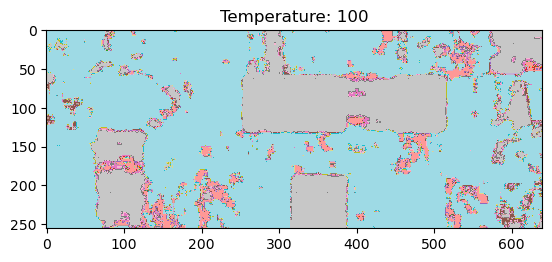

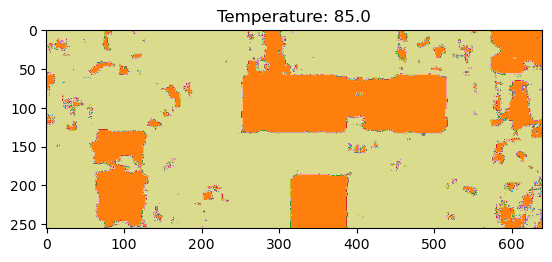

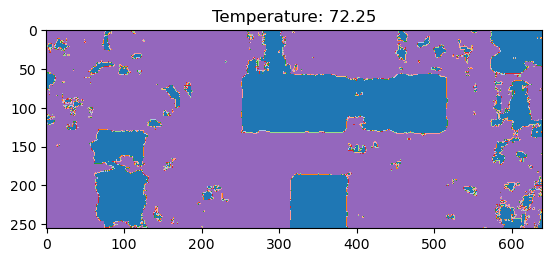

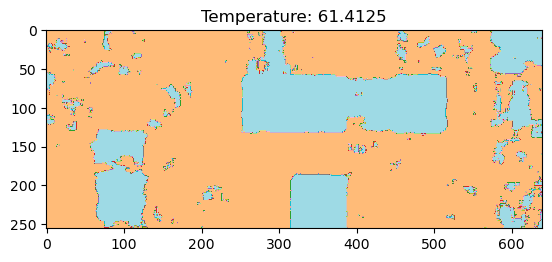

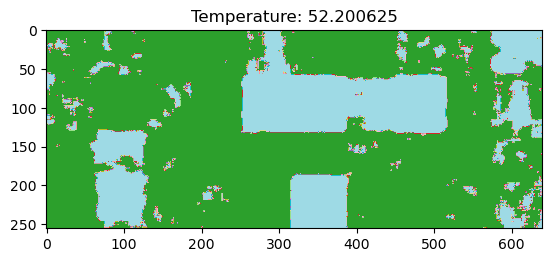

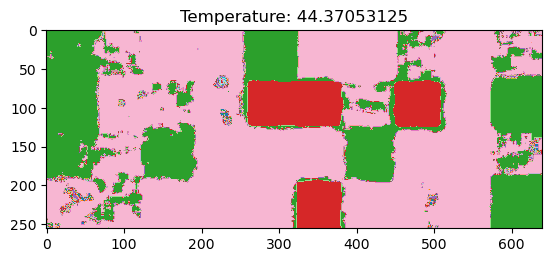

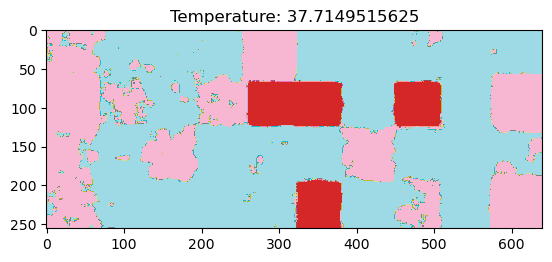

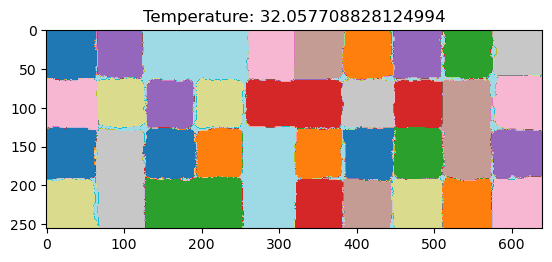

In [12]:
# Clustering at different temperatures
for temp in HC_detann2.centroids_dict.keys():
    predicted_perm_label_map = HC_detann2.predict(perm_texture, temp=temp)
    plt.imshow(predicted_perm_label_map, cmap="tab20")
    plt.title(f'Temperature: {temp}')
    plt.show()

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.